In [1]:
from __future__ import division
%matplotlib inline
import sys
path = '../PostBornEma/'
sys.path.append("../scripts/") 
import matplotlib.pyplot as plt
from postBornCrossSpectra import PostBorn_Bispec
import numpy as np
import Cosmology as C
import pickle
from scipy.integrate import simps
from scipy.interpolate import RectBivariateSpline
from classy import Class

import copy
import kernels
#plt.style.use('classic')
#plt.style.use(['seaborn-colorblind','paper'])


In [2]:
#Todos: noise with higher L sampling, L1 min stability test
from lab import *

using z-bin None norm 65.75020607931236
using z-bin [0, 0.5, 0.03] norm 14.32276056640902
using z-bin [0.5, 0.5, 0.03] norm 23.943209238913052
using z-bin [1.0, 1.0, 0.04] norm 21.63232752061847
using z-bin [2.0, 1.0, 0.05] norm 3.7179104375669816
using z-bin [3.0, 1.0, 0.05] norm 1.471852539963635


In [3]:
plotpath = './CrossPostBorn/results/plots/vanessa/'

In [4]:
zmin = 1e-5
zmax = 1090.

kmin = 1e-4
kmax = 50

cosmo_dict.pop('z_cmb')
cosmo = [{'name':"EmasCosmo"},cosmo_dict]
# cosmo = C.Planck2015

a     = np.linspace(1./(1.+zmin),1./(1.+zmax),500)  
z     = 1./a-1.

data  = C.CosmoData(cosmo[1],z)

L     = np.logspace(1,4,400)

# sampling for integrations
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1  = np.logspace(-1,5,400)

LSST_bins  = [0,1,2,3,4,'all']

computing distances, derived parameters...
{'Neff': 3.046}
{'h': 0.677}
{'m_ncdm_tot': 0.0}
{'omega_m': 0.6745515980724002}


In [5]:
zmins= [0,0.5,1,2,3,0]
zmaxs= [0.5,1.,2.,3.,4.,'z$_{\mathrm{CMB}}$']
ngal = [14.3,23.9,21.6,3.7,1.5,65.7]

colors=['navy','maroon', 'darkgreen', 'mediumaquamarine','indianred','darkorange']

In [6]:
#31 term only
def get_31_term_only(L,L1,M):
    return -L**2/np.pi*simps(M(L,L1)/L1,L1)


In [7]:
#compute correction following Krause&Hirata

# redefinition with l'-> l-l'
def get_regularized_sum_of_terms_old(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand =LL*LL1**3*(-LL1*nu+LL)*(-LL1+LL*nu)**2*(M(L_,LL1,grid=False)/L_**2/LL1**4-M(LL,LL1,grid=False)/LL**2/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res

#always use trapz rule for accurate results!
#redefinition with l'-> l'-l
def get_regularized_sum_of_terms(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand =LL*LL1**3*(LL1*nu+LL)*(LL1+LL*nu)**2*(M(L_,LL1,grid=False)/L_**2/LL1**4-M(LL,LL1,grid=False)/LL**2/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL*LL1**2*(-LL1*nu+LL)*(-LL1+LL*nu)**2-LL**2*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False)/LL**2/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res

#angular integration by hand
def get_second_sum_of_terms_exact(L,L1,M):
    res=[]
    for LL in L:
        integrand = LL**2*L1**5*(M(LL,L1,grid=False)/LL**2/L1**4)
        res+=[simps(integrand,L1)]   
    return 4*np.asarray(res)/np.pi

In [8]:
first_kernel  = kernels.CMB_lens(data.chi_cmb,data)
simple_kernel = kernels.CMB_lens(None,data)

Mstarspls = []
PBs =[]
Cls= []
for LSST_bin in LSST_bins:
    second_kernel = kernels.gal_clus(kernels.dNdz_LSST,kernels.simple_bias,data,LSST_bin)
    PB  = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=kmin,k_max=100, lmax=30000, acc=2)
    PBs+=[PB]
    Mstarspls+=[PB.Mstarsp]
    Cls+=[PB.CL_born]
ls = PB.ls


using z-bin [0, 0.5, 0.03] norm 14.32276056640902
Initializing CLASS with halofit...
{'A_s': 2.10732e-09, 'h': 0.677, 'k_pivot': 0.05, 'n_s': 0.96824, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'output': 'mPk', 'P_k_max_1/Mpc': 101, 'z_max_pk': 1088.6464513003662, 'k_min_tau0': 0.002, 'k_max_tau0_over_l_max': 5.0, 'k_step_sub': 0.015, 'k_step_super': 0.0001, 'k_step_super_reduction': 0.1, 'k_per_decade_for_pk': 20, 'perturb_sampling_stepsize': 0.01, 'tol_perturb_integration': 1e-06, 'halofit_k_per_decade': 3000.0, 'non linear': 'halofit'}
sigma8  0.822427245205793
zmax 1088.6464513003662
using z-bin [0.5, 0.5, 0.03] norm 23.943209238913052
Initializing CLASS with halofit...
{'A_s': 2.10732e-09, 'h': 0.677, 'k_pivot': 0.05, 'n_s': 0.96824, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'output': 'mPk', 'P_k_max_1/Mpc': 101, 'z_max_pk': 1088.6464513003662, 'k_min_tau0': 0.002, 'k_max_tau0_over_l_max': 5.0, 'k_step_sub': 0.015, 'k_step_super': 0.0001, 'k_step_super_reduction': 0.1, 'k_per_decad

In [9]:
corrs = []
for ii in range(len(LSST_bins)):
    print(ii)
    corrs+=[get_regularized_sum_of_terms(L,L1,phi,Mstarspls[ii],method='trapz')+get_second_sum_of_terms(L,L1,Mstarspls[ii],method='trapz')]

0
1
2
3
4
5


In [10]:
Cl13 = get_31_term_only(L,L1,Mstarspls[1])


In [11]:
#signal and noise plot
import Cosmology as Cosmo
params  = Cosmo.Planck2015
tag     = params[0]['name']
field   = 'mv'
nl      = True

thetaFWHMarcmin = 1. #beam FWHM
noiseUkArcmin   = 1. #eval(sys.argv[1]) #Noise level in uKarcmin
l_max_T         = 3000
l_max_P         = 5000
l_min           = 50
L_max           = 6000 #for l integration
L_min           = 1
TCMB            = 2.7255e6
div             = True #divide EB by factor of 2.5
exp             = 'CMB-S4'

if l_max_T!=l_max_P:
    lmax='mixedlmax_%d_%d'%(l_max_T,l_max_P)
else:
    lmax=str(l_max_T)
path='/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/'
noisepath='/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/noise_curves/'
ellpath="/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/ells/"
LL,l,theta = pickle.load(open(ellpath+'ell_ang_full_Lmin1_Lmax3000_lmin1_lmax8000_lenL120_lenl140_lenang120_1e-04.pkl','r'))
cls=[]
noise=[]
L_=np.arange(100,3000)
Delta=[]
jj=0
for LSST_bin in LSST_bins:
    cl       = np.load(path+'CL_kg_LSSTbin%s_full_Planck2015_Lmin1-Lmax2999_halofit.npy'%str(LSST_bin))
    ll,_,_,_,noise_gg,noise_kg,noise_kk = pickle.load(open(noisepath+'Gaussian_variances_%s_%s_LSSTbin%s_full_%s_%s.pkl'%(exp,lmax,str(LSST_bin),tag,'dndz_LSST_i27_SN5_3y'),'r'))
    cls      +=[np.interp(L_,LL,cl)]
    noise    +=[np.interp(L_,ll,noise_kg)]
    Delta    +=[np.interp(L_,L,corrs[jj])]
    jj+=1
    
plt.figure()
for ii in range(len(LSST_bins)):
    print(ii)
    plt.loglog(L_,cls[ii],c=colors[ii],label='z=%.1f-%s'%(zmins[ii],str(zmaxs[ii])))
    plt.loglog(ls,Cls[ii],c='y',ls='--')
    plt.fill_between(L_,cls[ii]-noise[ii],cls[ii]+noise[ii],color=colors[ii],alpha=0.1)
    plt.xlim(100,3000)
    plt.ylim(1e-9,2e-6)
plt.show()
    

plt.figure()
for ii in [0,1,2,3,4]:
    print(ii)
    plt.loglog(L_,-Delta[ii]/noise[ii],color=colors[ii],ls='-',lw='2',label='z=%.1f-%s'%(zmins[ii],str(zmaxs[ii])))
    plt.xlim(100,3000)
    plt.ylim(1e-6,1e-2)
    #plt.legend(loc=(1.02,0.5))
    plt.ylabel('$\Delta C_L^{\kappa g}/N$',fontsize=24)
    plt.xlabel('$L$',fontsize=20)
plt.savefig(plotpath+'cl_cross_over_noise.pdf', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/ells/ell_ang_full_Lmin1_Lmax3000_lmin1_lmax8000_lenL120_lenl140_lenang120_1e-04.pkl'

FileNotFoundError: [Errno 2] No such file or directory: './CrossPostBorn/results/plots/vanessa/cl_cross.pdf'

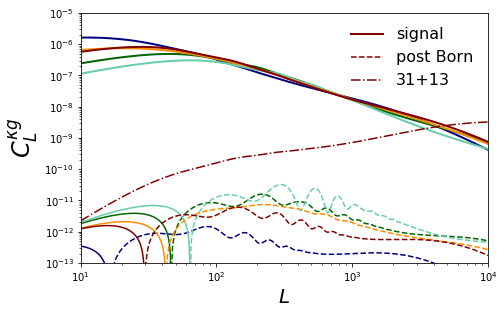

In [12]:
#signal and correction plot 
plt.figure(figsize=(7.3,4.6))
for ii in [0,2,3,5]:
    plt.loglog(ls,Cls[ii],c=colors[ii],lw=2)#,label='z=%.1f-%s'%(zmins[ii],str(zmaxs[ii])))
    plt.loglog(L,corrs[ii],lw=1.5,c=colors[ii],ls='-')
    plt.loglog(L,-corrs[ii],lw=1.5,c=colors[ii],ls='--')
ii=1
plt.loglog(ls,Cls[ii],c=colors[ii],lw=2,label='signal')#,label='z=%.1f-%s'%(zmins[ii],str(zmaxs[ii])))
plt.loglog(L,corrs[ii],c=colors[ii],lw=1.5,ls='-')
plt.loglog(L,-corrs[ii],c=colors[ii],lw=1.5,ls='--',label='post Born')
plt.loglog(L,-Cl13,ls='-.',c=colors[1],lw=1.5,label='31+13')
plt.ylabel('$C_L^{\kappa g}$',fontsize=24)
plt.xlabel('$L$',fontsize=20)
plt.xlim(10,10000)
plt.ylim(1e-13,1e-5)
plt.legend(loc='upper right', frameon=False,fontsize=16)
plt.savefig(plotpath+'cl_cross.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,4.3))
for ii in [0,1,2,3,5]:
    print(ii)
    plt.loglog(L_,-Delta[ii]/noise[ii],color=colors[ii],ls='-',lw='2',label='z=%.1f-%s'%(zmins[ii],str(zmaxs[ii])))
plt.xlim(100,3000)
plt.ylim(1e-6,5e-3)
plt.legend(loc='lower right',frameon=True,fontsize=16)
plt.ylabel('$\Delta C_L^{\kappa g}/$noise',fontsize=22)
plt.xlabel('$L$',fontsize=20)
plt.savefig(plotpath+'cl_cross_over_noise.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# binning
deltaL= 100
binned_corrs=[]
binned_noise=[]
for ii in np.arange(len(LSST_bins)):
    inc = 0
    res =[]
    res2=[]
    LL_=[]
    while inc<2900:
        res+=[np.mean(Delta[ii][inc:inc+deltaL])]
        res2+=[np.mean(noise[ii][inc:inc+deltaL])]
        inc+=deltaL
        LL_+=[np.mean(L_[inc:inc+deltaL])]
    binned_corrs+=[np.asarray(res)]
    binned_noise+=[np.asarray(res2)]

plt.figure()
for ii in [0,1,2,3,5]:
    print('bin',LSST_bins[ii])
    print 'tot PB/noise', np.sqrt(np.sum((binned_corrs[ii]/binned_noise[ii])**2))
    plt.semilogy(LL_,-binned_corrs[ii]/binned_noise[ii],color=colors[ii],ls='',marker='o',label='z=%.1f-%s'%(zmins[ii],str(zmaxs[ii])))
    plt.xlim(100,3000)
    plt.legend(loc=(1.02,0.5))
    plt.ylabel('$\Delta C_L^{\kappa g}/N$',fontsize=24)
    plt.xlabel('$L$',fontsize=20)
plt.savefig(plotpath+'cl_cross_over_noise_binned.pdf', bbox_inches='tight')




In [13]:
bin_num=5
#these two should be the same
reskk1 = get_regularized_sum_of_terms(L,L1,phi,Mstarspls[bin_num],method='trapz')
reskk1b= get_regularized_sum_of_terms_old(L,L1,phi,Mstarspls[bin_num],method='trapz')
#these two should be the same
reskk2 = get_second_sum_of_terms(L,L1,Mstarspls[bin_num],method='trapz')
reskk2b= get_second_sum_of_terms_exact(L,L1,Mstarspls[bin_num])


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.title('relative difference of two variable transforms')
plt.loglog(L, reskk1b/reskk1-1)
plt.loglog(L, -reskk1b/reskk1+1)
plt.xlabel('$L$',fontsize=20)
plt.show()
plt.savefig(plotpath+'firstIntegral_tests.pdf', bbox_inches='tight')

In [ ]:
# use trapezian rule
lstyles=['-','--','-.']
colors=['blue', 'crimson','green']
i=0
plt.figure()
plt.title('relative difference of analytic and numeric integral')
for method in ['simps','trapz','sum']:
    reskk_ = get_second_sum_of_terms(L,L1,Mstarspls[bin_num],method=method)
    plt.loglog(L, reskk_/reskk2b-1,label=method,ls=lstyles[i],c=colors[i])
    plt.loglog(L, -reskk_/reskk2b+1,label=method,ls=lstyles[i],c=colors[i])
    i+=1
plt.xlabel('$L$',fontsize=20)
plt.legend()
plt.show()
plt.savefig(plotpath+'integral_tests.pdf', bbox_inches='tight')

In [ ]:
plt.figure()
plt.loglog(ls,Cls[bin_num],label='(11) term')
plt.loglog(L, -reskk1,label='integral 1')
plt.loglog(L, reskk2,ls='--',label='integral 2',color='coral')
plt.loglog(L, reskk1+reskk2,ls='--',label='diff',color='crimson')
plt.loglog(L, -(reskk1+reskk2),ls='-',color='crimson')
plt.loglog(L, reskk2b,ls='-.',label='integral 2 exact')
plt.loglog(L, reskk1+reskk2b,ls='-',label='diff 2 ',color='cyan')
plt.loglog(L, -(reskk1+reskk2b),ls='--',color='cyan')
plt.xlim(10,10000)
plt.ylim(1e-13,1e-6)
plt.legend(loc=(1.05,0.35))
plt.ylabel('$C_L^{\kappa\kappa}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.savefig(plotpath+'cl_cross_pB_tests%s.pdf'%LSST_bin, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
plt.loglog(ls,Cls[bin_num],label='(11) term')
plt.loglog(L, -reskk1,label='integral 1')
plt.loglog(L, reskk2,ls='--',label='integral 2',color='coral')
plt.loglog(L, reskk1+reskk2,ls='--',label='diff',color='crimson')
plt.loglog(L, -(reskk1+reskk2),ls='-',color='crimson')
plt.loglog(L, reskk2b,ls='-.',label='integral 1 old way')
plt.loglog(L, reskk1b+reskk2b,ls='-',label='diff 2 ',color='cyan')
plt.loglog(L, -(reskk1b+reskk2b),ls='--',color='cyan')
plt.xlim(10,10000)
plt.ylim(1e-13,1e-6)
plt.legend(loc=(1.05,0.35))
plt.ylabel('$C_L^{\kappa\kappa}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.savefig(plotpath+'cl_cross_pB_tests_2%s.pdf'%LSST_bin, bbox_inches='tight')
plt.show()

In [ ]:
# test case: reproduce Antony's results
first_kernel  = kernels.CMB_lens(data.chi_cmb,data)
simple_kernel = kernels.CMB_lens(None,data)
second_kernel = kernels.CMB_lens(data.chi_cmb,data)


PB_auto = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=kmin,k_max=100, lmax=30000, acc=2)

In [ ]:
#compute correction following Krause&Hirata
def get_regularized_sum_of_terms_auto(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand =LL**2*LL1**3*(LL1*nu+LL)**2*(LL1+LL*nu)**2*(M(L_,LL1,grid=False)/L_**4/LL1**4-M(LL,LL1,grid=False)/LL**4/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res



def get_second_sum_of_terms_auto(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL**2*LL1**2*(LL1*nu+LL)**2*(LL1+LL*nu)**2-LL**4*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False)/LL**4/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res

In [ ]:
resauto1 = get_regularized_sum_of_terms_auto(L,L1,phi,PB_auto.Mstarsp)
resauto2 = get_second_sum_of_terms_auto(L,L1,PB_auto.Mstarsp)

In [ ]:
plt.figure(figsize=(6,4))
plt.loglog(PB_auto.ls,PB_auto.CL_born,lw=2,label='signal')
plt.loglog(L, resauto1+resauto2,ls='--',lw=2,color='crimson')
plt.loglog(L, -(resauto1+resauto2),ls='-',lw=2,color='crimson',label='correction')
plt.xlim(10,10000)
plt.ylim(1e-13,1e-6)
plt.legend(loc='best',fontsize=14, frameon=False)
plt.ylabel('$C_L^{\kappa\kappa}$',fontsize=24)
plt.xlabel('$L$',fontsize=20)
#plt.savefig(plotpath+'cl_auto_pB_tests.pdf', bbox_inches='tight')
plt.show()

In [ ]:
L     = np.logspace(np.log(2),3,200)
L1,L2 = np.meshgrid(L,L)
np.save('../output/MLimberClKappaAuto',[L1,L2,4*PB_auto.Mstarsp(L,L)/L1**4/L2**4])